In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [4]:
data = pd.read_csv("./mock_kaggle.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/mock_kaggle.csv'

In [47]:
data.head()

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [48]:
data.columns = ['date','Sales','Stock','price']

In [49]:
data['date'] = pd.to_datetime(data['date'])

In [50]:
data.head()

,date,Sales,Stock,price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [51]:
df = data[['date','Sales']]

In [52]:
df.set_index('date',inplace=True)

In [53]:
df = df.asfreq('D')
df = df.fillna(method='ffill').astype(float)


/tmp/ipykernel_30/3377879730.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').astype(float)


In [54]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,943.0,90.492047,80.469137,0.0,33.5,76.0,127.0,542.0


<Axes: xlabel='date'>

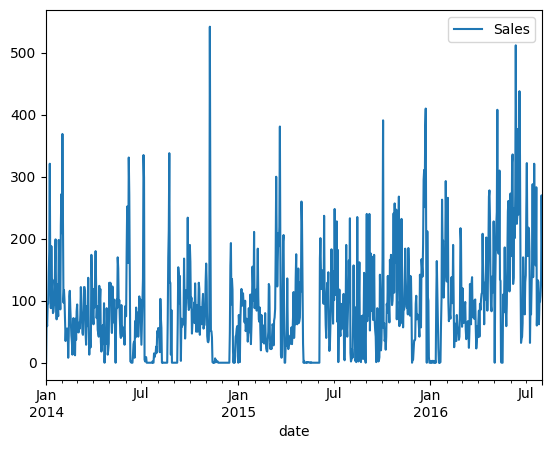

In [55]:
df.plot()

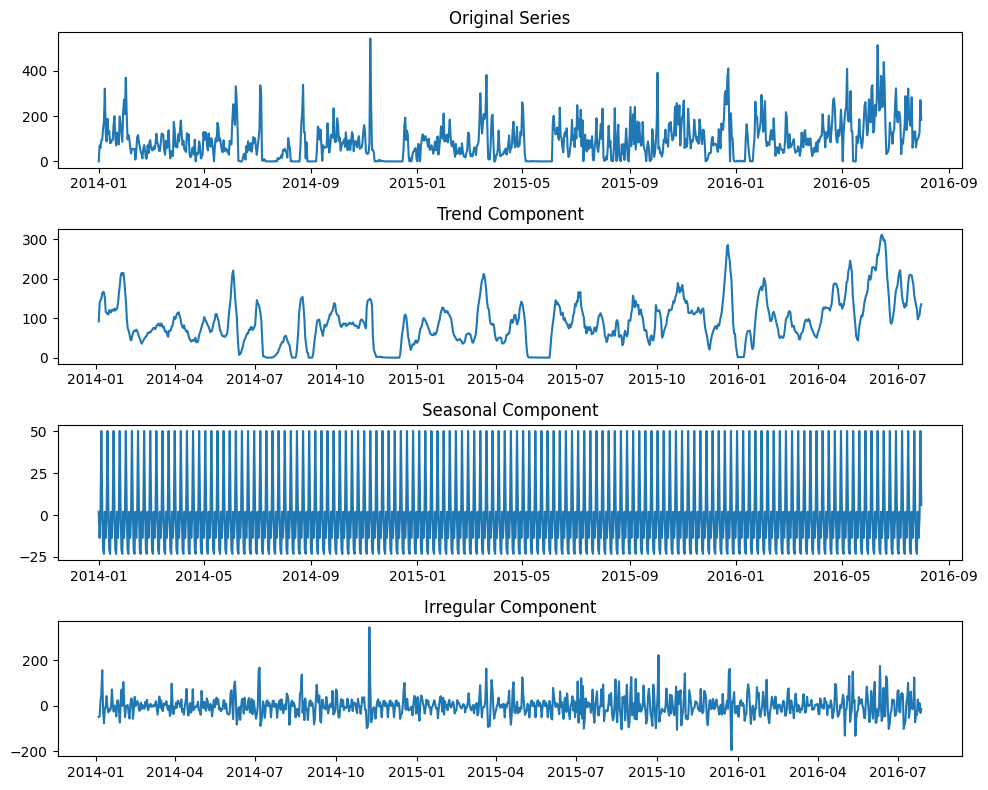

In [56]:
decomposed = seasonal_decompose(df, model = "additive")

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.set_title('Original Series')
ax1.plot(df)
ax2.set_title('Trend Component')
ax2.plot(decomposed.trend)
ax3.set_title('Seasonal Component')
ax3.plot(decomposed.seasonal)
ax4.set_title('Irregular Component')
ax4.plot(decomposed.resid)
plt.tight_layout()
plt.show()

In [57]:
print(f"Mean of residuals : {decomposed.resid.mean()}")

Mean of residuals : -0.03001220688028138


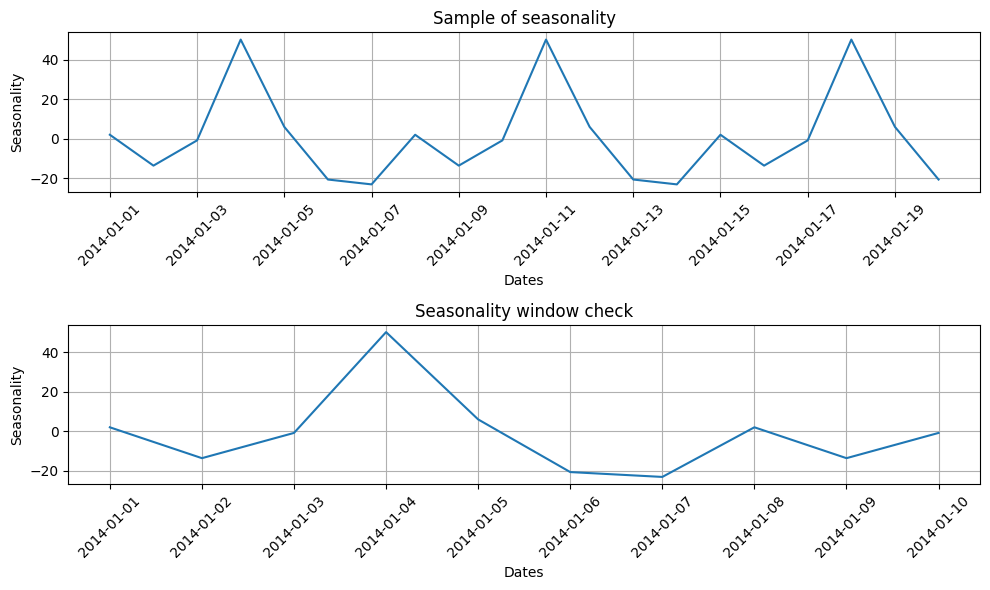

In [58]:
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(decomposed.seasonal[:20])
plt.xticks(rotation=45)
plt.xlabel('Dates')
plt.ylabel('Seasonality')
plt.title('Sample of seasonality')

plt.grid()


plt.subplot(212)

plt.plot(decomposed.seasonal[:10])
plt.xticks(rotation=45)
# Add labels and title
plt.title('Seasonality window check')

plt.xlabel('Dates')
plt.ylabel('Seasonality')
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

In [59]:
test_result = adfuller(df)

print(f"Test statistic :{test_result[0]}")
print(f"p-value :{test_result[1]}")


Test statistic :-4.778979266351844
p-value :5.965176191767525e-05


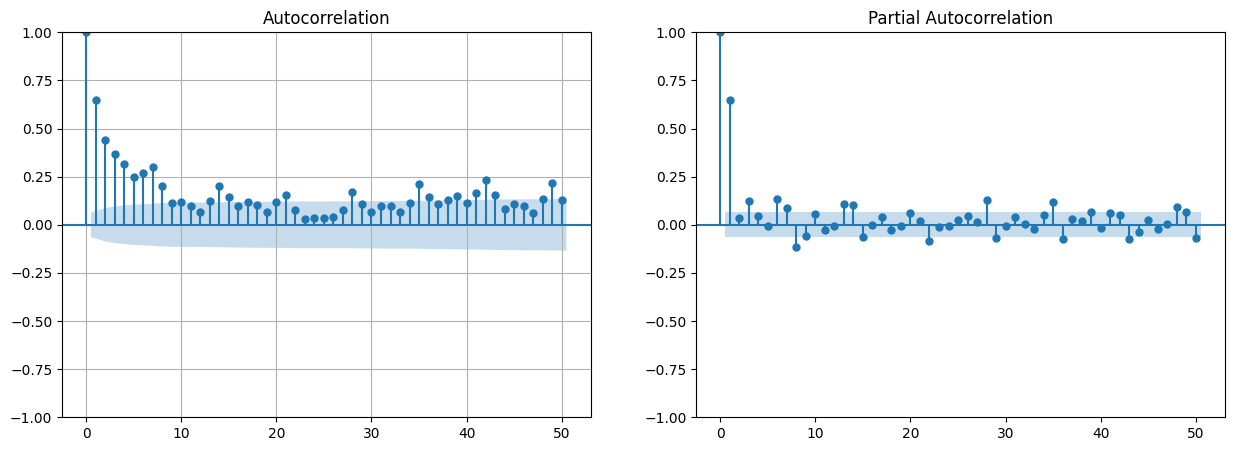

In [60]:

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
plot_acf(df,ax=plt.gca(),lags=50)
plt.grid()

plt.subplot(122)
plot_pacf(df, ax = plt.gca(), lags=50)
plt.show()

In [61]:
# Split into training and test sets (80% training, 20% test)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


In [62]:
## Building ARIMA model for below parameters

arima_model = ARIMA(train, order=(1, 0, 1),enforce_stationarity=False, enforce_invertibility=False)
arima_fit = arima_model.fit()


In [63]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  754
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -4124.179
Date:                Thu, 10 Oct 2024   AIC                           8256.358
Time:                        11:25:28   BIC                           8274.849
Sample:                    01-01-2014   HQIC                          8263.482
                         - 01-24-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.3821      7.934      9.879      0.000      62.831      93.933
ar.L1          0.6497      0.037     17.748      0.000       0.578       0.721
ma.L1         -0.0697      0.044     -1.578      0.1

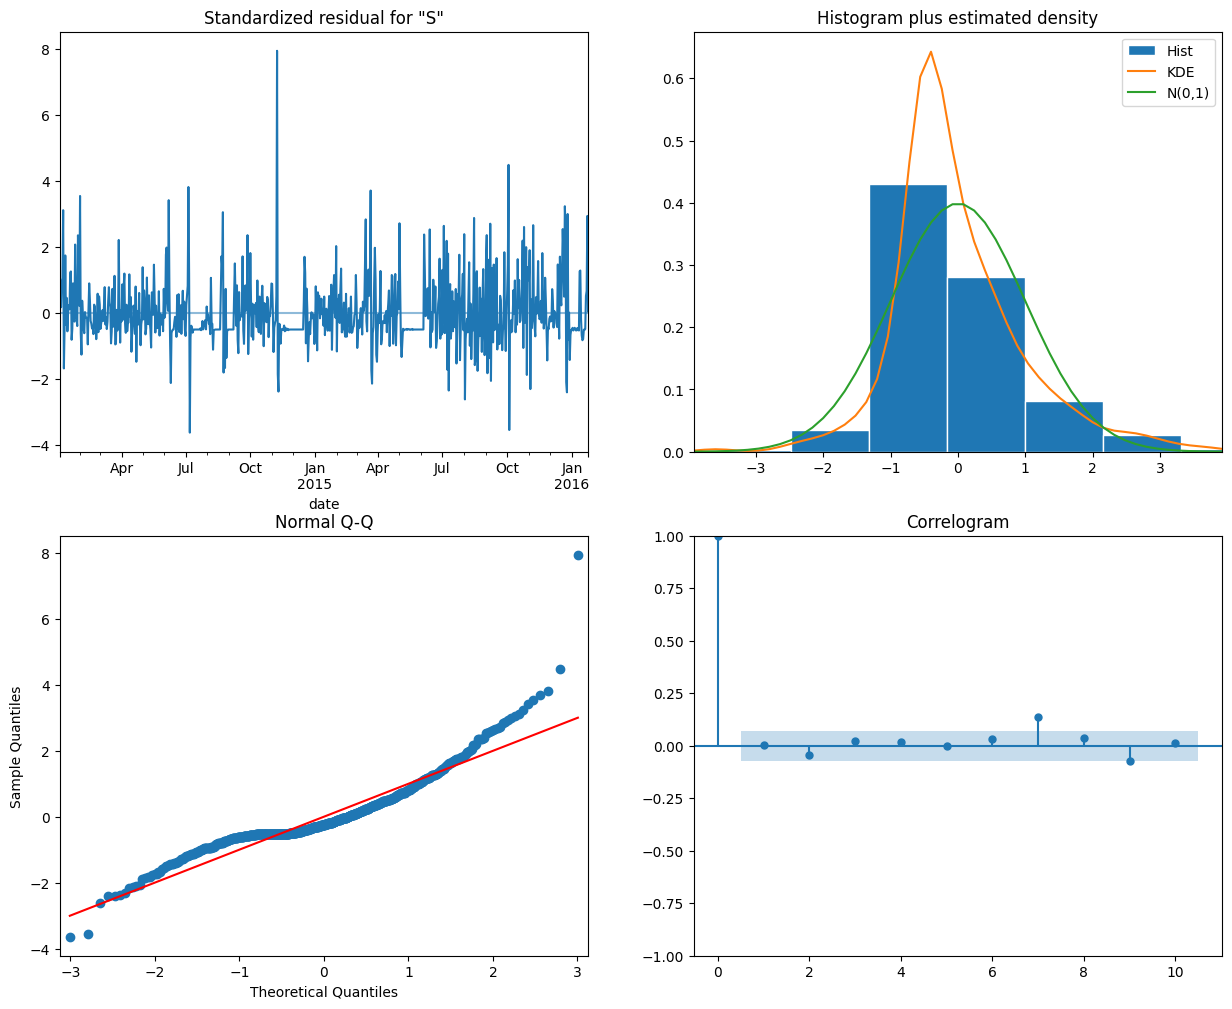

In [64]:
arima_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

Plot 1 - Residual plot - The mean of residuals are expected at 0 (white noise) which can be seen in the plot.  
Plot 2 - Histogram - The residuals are alomost normally distributed which is good, but distribution looks skewed  
Plot 3 - Q-Q plot - This plot clearly shows the skeweness in the tails and curve shape which is not expected.  
Plot 4 - Correlelogram - The residuals from lag do not shows any correlation with their lag values, except a small positive at 7th lag which could be because of untreated seasonal effect




Mean of residuals : 0.10572315636894854


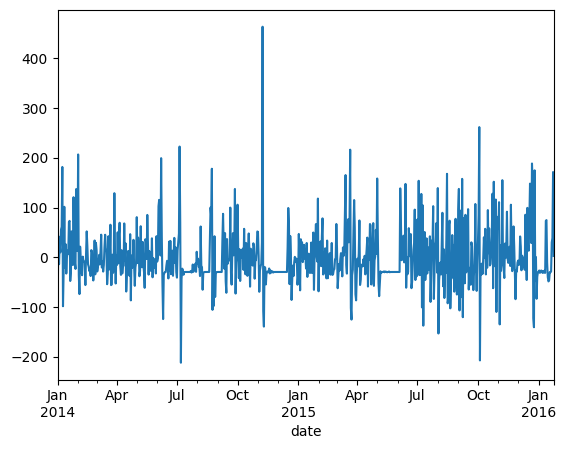

In [65]:
arima_fit.resid.plot()
print(f"Mean of residuals : {arima_fit.resid.mean()}")

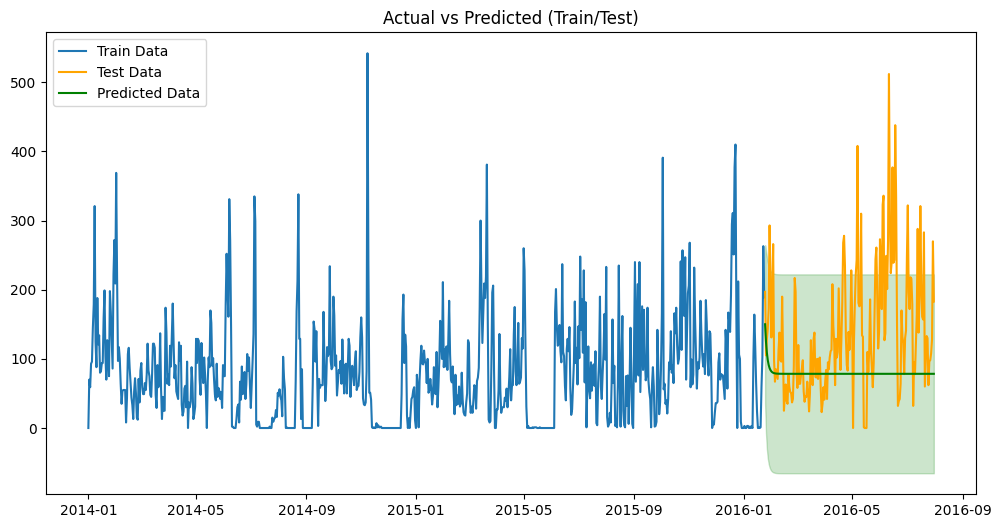

In [66]:
# Predictions on the Test Set
pred = arima_fit.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
pred_mean = pred.predicted_mean
pred_conf = pred.conf_int()

# Actual vs Predicted vs Test Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(pred_mean.index, pred_mean, label='Predicted Data', color='green')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='green', alpha=0.2)
plt.legend(loc='upper left')
plt.title('Actual vs Predicted (Train/Test)')
plt.show()

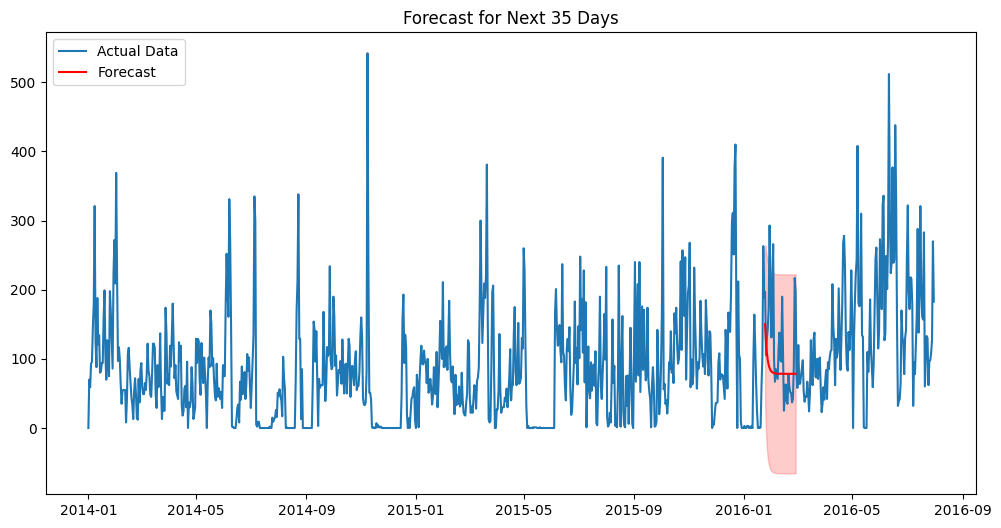

In [67]:
# Forecast for Next 35 Days
forecast = arima_fit.get_forecast(steps=35)
forecast_mean = forecast.predicted_mean
forecast_conf = forecast.conf_int()

# Forecast Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df, label='Actual Data')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_conf.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1], color='red', alpha=0.2)
plt.legend(loc='upper left')
plt.title('Forecast for Next 35 Days')
plt.show()


In [68]:
#  Calculate RMSE for Test Set
rmse = np.sqrt(mean_squared_error(test, pred_mean))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 107.25356854351347


In [69]:
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7), enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)


In [70]:
print(sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  754
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -4045.987
Date:                           Thu, 10 Oct 2024   AIC                           8101.975
Time:                                   11:25:32   BIC                           8125.042
Sample:                               01-01-2014   HQIC                          8110.866
                                    - 01-24-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7146      0.029     24.617      0.000       0.658       0.771
ma.L1         -0.1254      0.041     -3.057

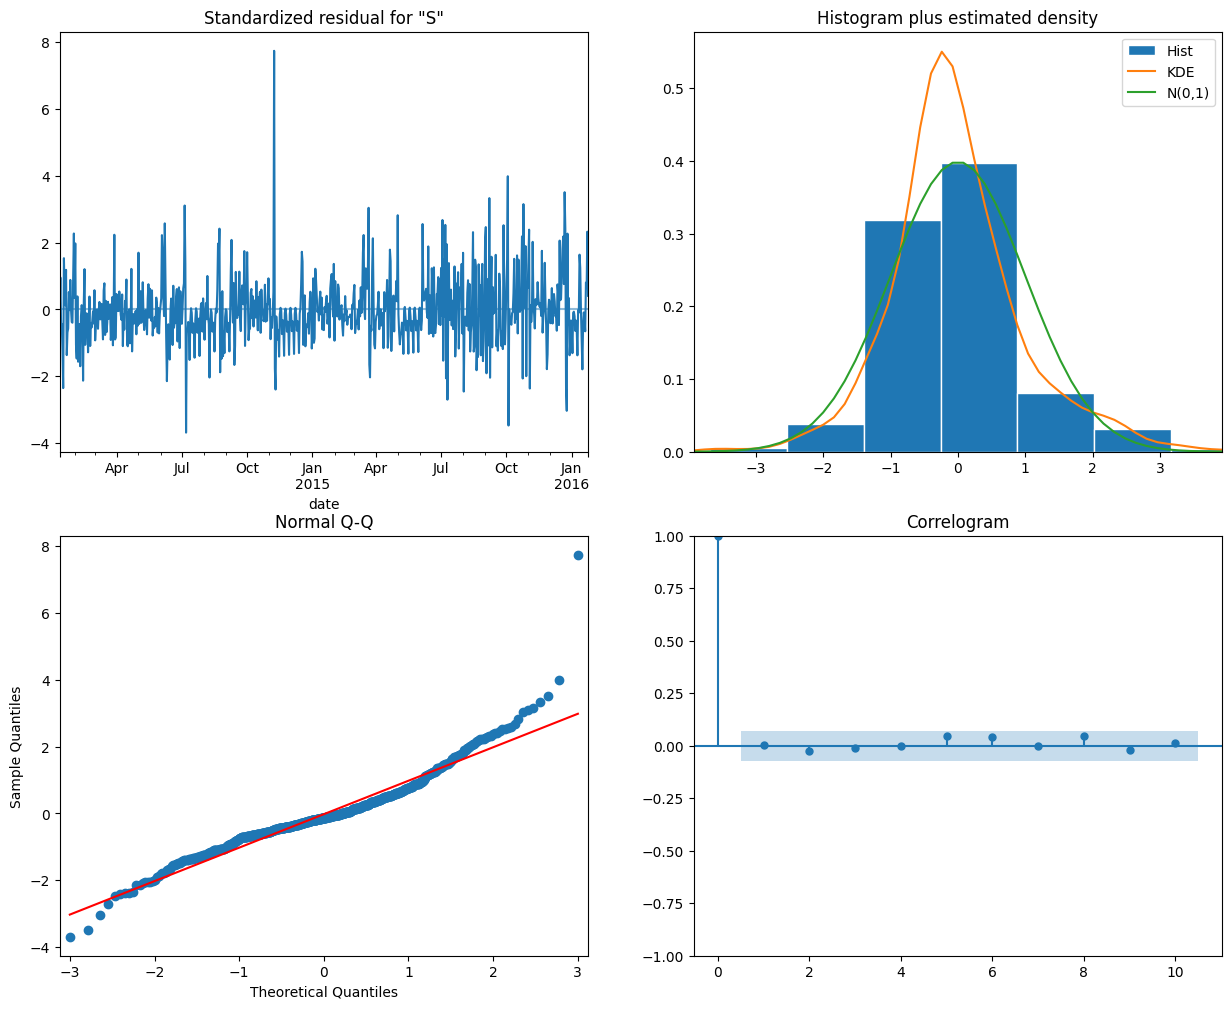

In [71]:
# Model Diagnostics
sarima_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

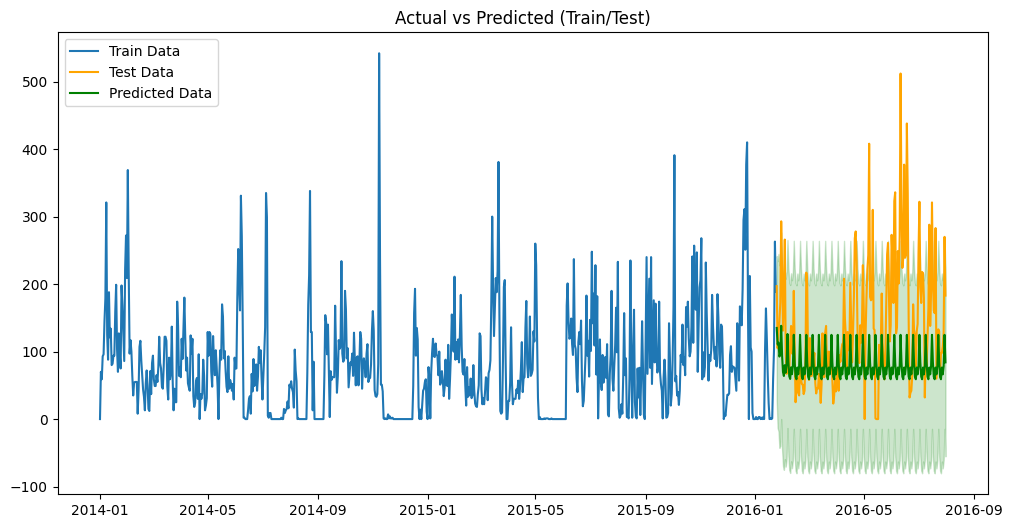

In [72]:
# Predictions on the Test Set

pred = sarima_fit.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
pred_mean = pred.predicted_mean
pred_conf = pred.conf_int()

#  Actual vs Predicted vs Test Plot

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(pred_mean.index, pred_mean, label='Predicted Data', color='green')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='green', alpha=0.2)
plt.legend(loc='upper left')
plt.title('Actual vs Predicted (Train/Test)')
plt.show()

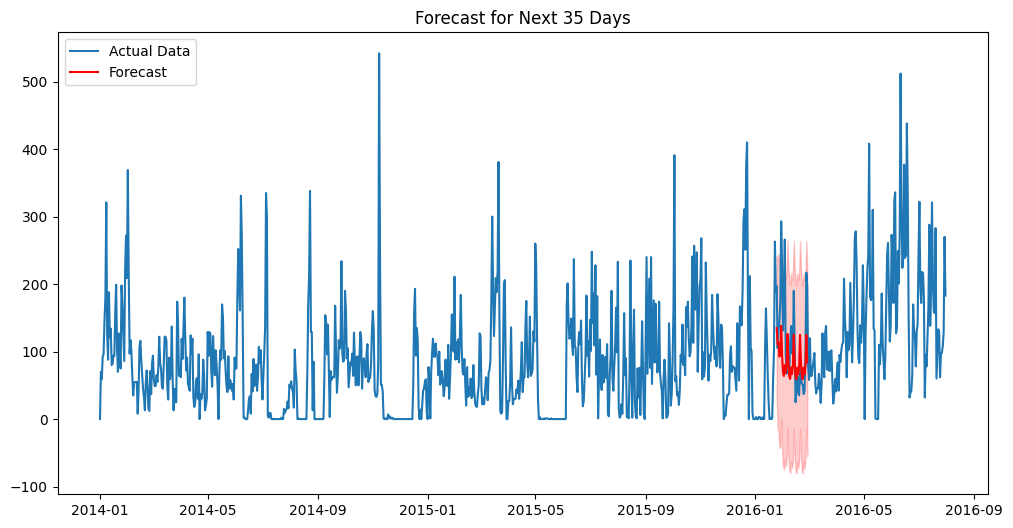

In [73]:

# Forecast for Next 35 Days
forecast = sarima_fit.get_forecast(steps=35)
forecast_mean = forecast.predicted_mean
forecast_conf = forecast.conf_int()

# Forecast Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df, label='Actual Data')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_conf.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1], color='red', alpha=0.2)
plt.legend(loc='upper left')
plt.title('Forecast for Next 35 Days')
plt.show()

In [74]:
# Calculate RMSE for Test Set

rmse = np.sqrt(mean_squared_error(test, pred_mean))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 102.19468822464155


In [75]:
# Resampling for each week

df = df.resample('W').sum()

In [76]:
df.head()

,Sales
date,
2014-01-05,318.0
2014-01-12,1167.0
2014-01-19,842.0
2014-01-26,838.0
2014-02-02,1500.0


<Axes: xlabel='date'>

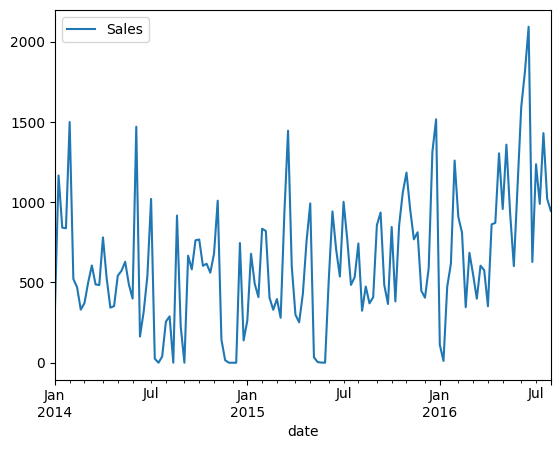

In [77]:
df.plot()

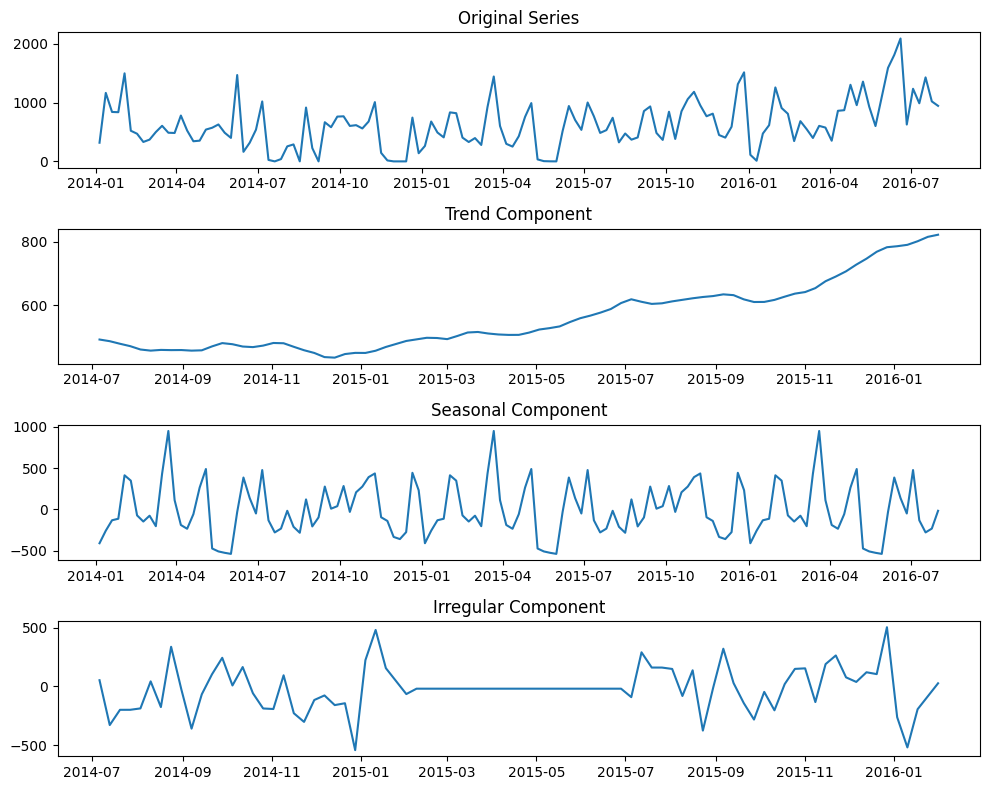

In [78]:
decomposed = seasonal_decompose(df, model = "additive")

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.set_title('Original Series')
ax1.plot(df)
ax2.set_title('Trend Component')
ax2.plot(decomposed.trend)
ax3.set_title('Seasonal Component')
ax3.plot(decomposed.seasonal)
ax4.set_title('Irregular Component')
ax4.plot(decomposed.resid)
plt.tight_layout()
plt.show()

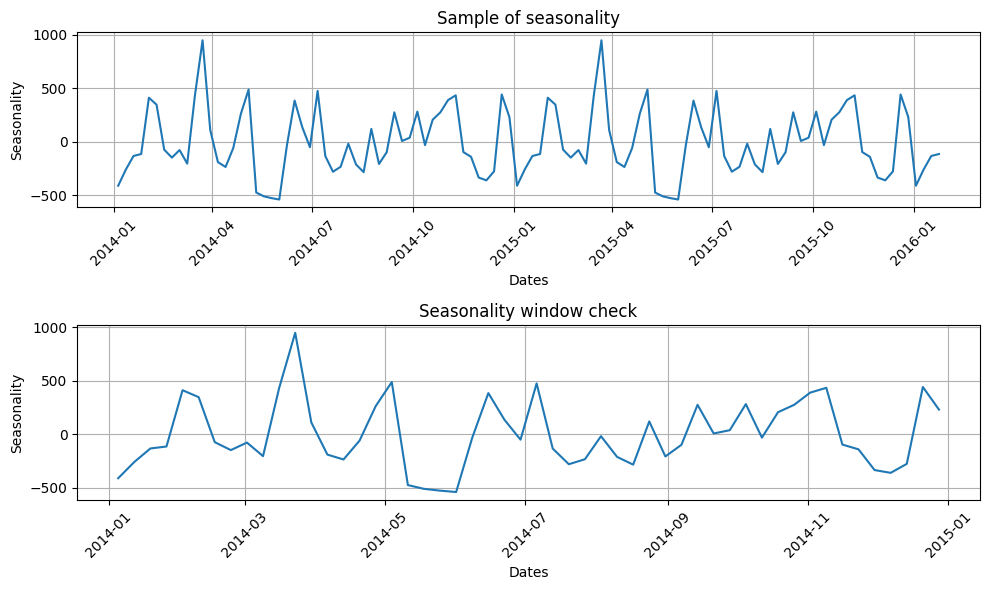

In [79]:
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(decomposed.seasonal[:108])
plt.xticks(rotation=45)
plt.xlabel('Dates')
plt.ylabel('Seasonality')
plt.title('Sample of seasonality')

plt.grid()


plt.subplot(212)

plt.plot(decomposed.seasonal[:52])
plt.xticks(rotation=45)
# Add labels and title
plt.title('Seasonality window check')

plt.xlabel('Dates')
plt.ylabel('Seasonality')
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

In [80]:
test_result = adfuller(df)

print(f"Test statistic :{test_result[0]}")
print(f"p-value :{test_result[1]}")


Test statistic :-2.378631316182882
p-value :0.14785860790405242


In [81]:
test_result = adfuller(df.diff().dropna())

print(f"Test statistic :{test_result[0]}")
print(f"p-value :{test_result[1]}")


Test statistic :-9.400474228671824
p-value :6.20716162465376e-16


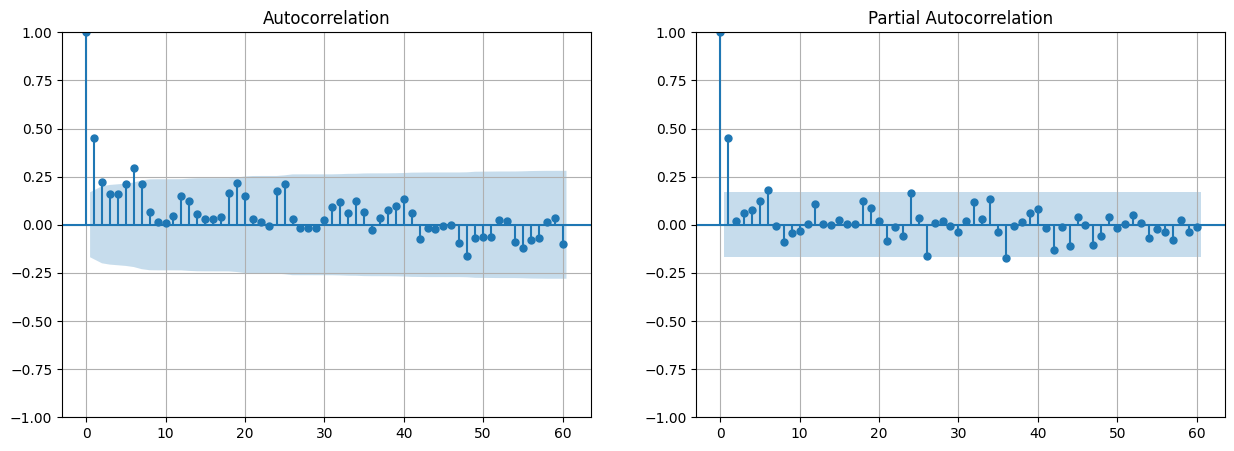

In [82]:

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
plot_acf(df,ax=plt.gca(),lags=60)
plt.grid()

plt.subplot(122)
plot_pacf(df, ax = plt.gca(), lags=60)
plt.grid()

plt.show()

In [83]:
# Split into training and test sets (80% training, 20% test)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


In [84]:
#  parameters
p = 1   # AR order
d = 1    # Differencing order
q = 1    # MA order
P = 1    # Seasonal AR order
D = 1    # Seasonal differencing order
Q = 1    # Seasonal MA order
s = 52   # Seasonal period 

sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))


In [85]:
start_params = [0.5] * p + [0.5] * q + [0.5] * P + [0.5] * Q + [1] * (P + Q)  # Adjust as needed
# Fit the model
try:
    sarima_fit = sarima_model.fit()  # Suppress output
    print(sarima_fit.summary())
except ValueError as e:
    print("Error fitting model:", e)



/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86605D+00    |proj g|=  5.10179D-02

At iterate    5    f=  3.84952D+00    |proj g|=  2.06536D-03

At iterate   10    f=  3.84814D+00    |proj g|=  1.35890D-02

At iterate   15    f=  3.84669D+00    |proj g|=  3.19804D-03

At iterate   20    f=  3.84659D+00    |proj g|=  8.87946D-04

At iterate   25    f=  3.84427D+00    |proj g|=  7.26592D-03

At iterate   30    f=  3.83341D+00    |proj g|=  8.01252D-04

At iterate   35    f=  3.83335D+00    |proj g|=  6.65328D-04

At iterate   40    f=  3.83334D+00    |proj g|=  4.04987D-05

At iterate   45    f=  3.83334D+00    |proj g|=  1.95745D-04
  ys=-1.153E-03  -gs= 3.127E-05 BFGS update SKIPPED

At iterate   50    f=  3.83224D+00    |proj g|=  3.03505D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -413.882
Date:                            Thu, 10 Oct 2024   AIC                            837.763
Time:                                    11:25:55   BIC                            847.800
Sample:                                01-05-2014   HQIC                           841.644
                                     - 01-24-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3649      0.305      1.196      0.232      -0.233       0.963
ma.L1         -0.9097      0.161   

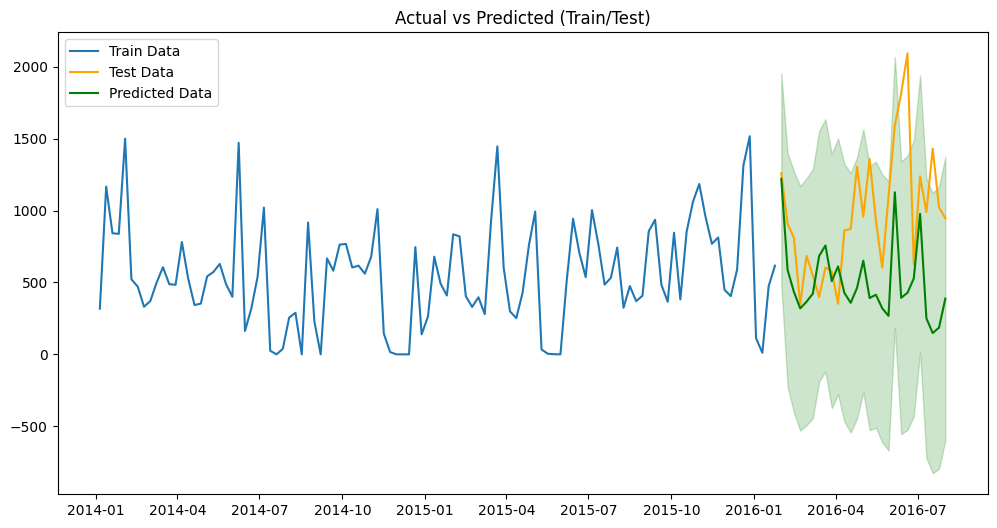

In [86]:
#  Predictions on the Test Set
pred = sarima_fit.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
pred_mean = pred.predicted_mean
pred_conf = pred.conf_int()

#  Actual vs Predicted vs Test Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(pred_mean.index, pred_mean, label='Predicted Data', color='green')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='green', alpha=0.2)
plt.legend(loc='upper left')
plt.title('Actual vs Predicted (Train/Test)')
plt.show()

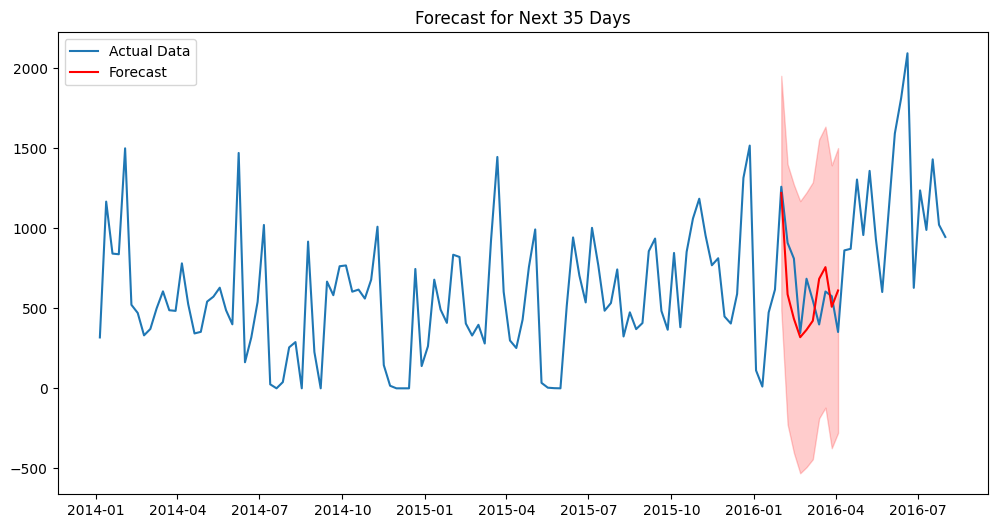

In [87]:
# Forecast for Next 35 Days
forecast = sarima_fit.get_forecast(steps=10)
forecast_mean = forecast.predicted_mean
forecast_conf = forecast.conf_int()

# Forecast Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df, label='Actual Data')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_conf.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1], color='red', alpha=0.2)
plt.legend(loc='upper left')
plt.title('Forecast for Next 35 Days')
plt.show()

In [88]:
#  Calculate RMSE for Test Set
rmse = np.sqrt(mean_squared_error(test, pred_mean))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 668.3968160208742
